# Table of Contents <a id='top'></a> 
                                                          

1. [Import Packages](#imports)<br>
2. [Define Functions](#functions)<br> 
3. [Conduct Experiments](#experiments)<br> 
4. [Visualize Results](#visualize)<br> 

---
## 1: Import Packages <a id='imports'></a> 
[jump to top](#top)<br>

In [1]:
# modules I created
from bidder import Bidder
from auction import Auction, User

# outside libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

--- 
## 2: Define Functions <a id='functions'></a> 
[jump to top](#top)<br>

In [2]:
def run_experiment(auction):
    """Take an auction object and call .execute() repeatedly to run many rounds. The exact number of rounds
    is determined by the num_rounds attribute of the bidders within the auction"""
    
    for i in range(auction.bidders[0].num_rounds):
        auction.execute_round()

In [3]:
def overview(auction):
    """Given a completed auction (an auction object for which .execute() has been repeatedly called),
    summarize the attributes of the bidders involved and indicate the final balance of each bidder"""
    
    dicty = {"bidder_id": [],
             "bidder_type": [],
             "alpha": [],
             "aggressiveness": [],
             "under_cut": [],
             "num_users": [],
             "final_balance": []}

    for bidder in auction.bidders:
        dicty["bidder_id"].append(bidder.bidder_id)
        dicty["bidder_type"].append(bidder.bidder_type)
        if bidder.bidder_type == "smart":
            dicty["alpha"].append(bidder.alpha)
            dicty["aggressiveness"].append(bidder.aggressiveness)
            dicty["under_cut"].append(bidder.under_cut)
        else:
            dicty["alpha"].append("NA")
            dicty["aggressiveness"].append("NA")
            dicty["under_cut"].append("NA")
        dicty["num_users"].append(len(auction.users))
        dicty["final_balance"].append(auction.balances[bidder])

    summary_df = pd.DataFrame(dicty)
    
    return summary_df


--- 
## 3: Conduct Experiments <a id='experiments'></a> 
[jump to top](#top)<br>

**Create 1000 different bidders, each defined by a unique combination of `alpha`, `aggressiveness`, and `under_cut`. These bidders will compete against each other in many, many auctions and I will keep track of their performance across auctions to determine which are the best and worst bidders.**

`alpha` will take on values in $[0, 0.9]$ by increments of $0.1$ <br>
`aggressiveness` will take on values in $[0, 0.95]$ by increments of $0.05$ <br>
`undercut` will take on values in $[0, 0.2]$ by increments of $0.05$ <br>

In [4]:
# define the support of the discrete variables alpha, aggressiveness, and under_cut
alpha_levels = [i/10 for i in range(10)]
aggressiveness_levels = [i/20 for i in range(20)]
under_cut_levels = [i/20 for i in range(0, 5)]

# initialize an empty dictionary and then populate it with all the different combinations of the three variables
dict_bidders = {"bidder_id":[], "alpha": [], "aggressiveness": [], "under_cut": []}
i = 0
for alpha in alpha_levels:
    for agg in aggressiveness_levels:
        for undercut in under_cut_levels:
            dict_bidders["bidder_id"].append(i)
            dict_bidders["alpha"].append(alpha)
            dict_bidders["aggressiveness"].append(agg)
            dict_bidders["under_cut"].append(undercut)
            i += 1

# create a dataframe from the above dictionary and add columns which will later track the bidders' success            
df_bidders = pd.DataFrame(dict_bidders)  
df_bidders["num_auctions_played"] = [0 for i in range(len(df_bidders))]
df_bidders["total_balance"] = [0 for i in range(len(df_bidders))]
df_bidders['average_final_balance'] = df_bidders.apply(
    lambda row: row['total_balance'] / row['num_auctions_played'] if row['num_auctions_played'] != 0 else 0,
    axis=1
)

# view the dataframe
df_bidders

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
0,0,0.0,0.00,0.00,0,0,0
1,1,0.0,0.00,0.05,0,0,0
2,2,0.0,0.00,0.10,0,0,0
3,3,0.0,0.00,0.15,0,0,0
4,4,0.0,0.00,0.20,0,0,0
...,...,...,...,...,...,...,...
995,995,0.9,0.95,0.00,0,0,0
996,996,0.9,0.95,0.05,0,0,0
997,997,0.9,0.95,0.10,0,0,0
998,998,0.9,0.95,0.15,0,0,0


To be clear, each row of the above dataframe represents a different bidder. I will draw a few bidders from this dataframe each time I create an auction. I will repeat this process many times until each bidder has been drawn at least 10 times. Note that the columns `num_auctions_played`, `total_balance`, and `average_final_balance` are initialized with zeros because the bidders haven't participated in any auctions yet. 

In [5]:
def run_record_auction():
    """Calling this function modifies the df_bidders dataframe created above by populating it with the
    performance of the involved bidders after a single auction definition has executed 1000 rounds"""
    
    # instantiate 10 users
    users = [User() for i in range(10)]
    
    # decide how many smart bidders will participate, it will be anywhere from 5 to 9
    num_bidders = np.random.randint(5, 10)

    # randomly select num_bidders bidders from the table df_bidders 
    bidders_ids = np.random.choice(df_bidders.index, num_bidders)
    
    # instantiate the bidders with the attributes defined in the df_bidders table
    bidders = [Bidder(num_users=10, num_rounds=1000, bidder_type="zero")] + [Bidder(10, 1000, bidder_id = bidders_ids[i], bidder_type="smart", alpha=df_bidders.loc[bidders_ids[i]][1], aggressiveness=df_bidders.loc[bidders_ids[i]][2], under_cut=df_bidders.loc[bidders_ids[i]][3]) for i in range(num_bidders)] + [Bidder(num_users=10, num_rounds=1000, bidder_type="random")]
    
    # instantiate the auction with the users and bidders created above
    auction = Auction(users, bidders)
    
    # execute 1000 rounds of the auction
    run_experiment(auction)
    
    # summarize the outcome of the auction
    overview_df = overview(auction)
    
    # record the results of the auction in the df_bidders dataframe
    smart_bidders_df = overview_df[overview_df["bidder_type"]=="smart"]
    smart_bidders_df = smart_bidders_df.reset_index()
    for i in range(len(smart_bidders_df)):
        final_balance = smart_bidders_df.loc[i, "final_balance"]
        bidder_id = smart_bidders_df.loc[i, "bidder_id"]
        df_bidders.loc[bidder_id, "total_balance"] += final_balance
        df_bidders.loc[bidder_id, "num_auctions_played"] += 1
        df_bidders.loc[bidder_id, "average_final_balance"] = df_bidders.loc[bidder_id, "total_balance"] / df_bidders.loc[bidder_id, "num_auctions_played"]

Below, I call the `run_record_auction()` function 4000 times to ensure that each of the 1000 bidders participate in at least 10 auctions. 

In [6]:
# run the experiment repeatedly and time how long it takes

import time

a = time.time()

for i in range(4000):
    run_record_auction()

b = time.time()

print(round(b-a, 2), "seconds")

64.36 seconds


In [7]:
# see which bidders did best and worst

df_bidders.sort_values(by="average_final_balance", ascending=False)

,bidder_id,alpha,aggressiveness,under_cut,num_auctions_played,total_balance,average_final_balance
186,186,0.1,0.85,0.05,37,1303.880473,35.240013
155,155,0.1,0.55,0.00,29,934.013054,32.207347
185,185,0.1,0.85,0.00,29,829.982307,28.620080
190,190,0.1,0.90,0.00,31,677.239284,21.846429
560,560,0.5,0.60,0.00,19,412.631293,21.717436
...,...,...,...,...,...,...,...
897,897,0.8,0.95,0.10,23,-4104.223721,-178.444510
998,998,0.9,0.95,0.15,22,-3983.805346,-181.082061
995,995,0.9,0.95,0.00,25,-4551.239990,-182.049600
899,899,0.8,0.95,0.20,23,-4187.684917,-182.073257


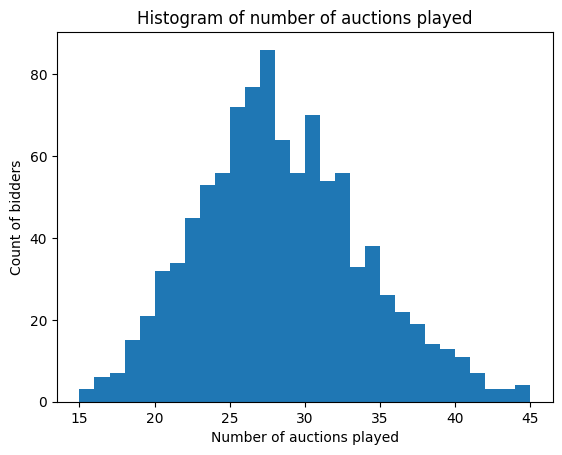

In [8]:
# look at the full distribution of num_auctions_played

min_ = df_bidders[["num_auctions_played"]].describe().loc["min", "num_auctions_played"]
max_ = df_bidders[["num_auctions_played"]].describe().loc["max", "num_auctions_played"]

plt.hist(df_bidders.num_auctions_played, bins=int(max_-min_))
plt.xlabel("Number of auctions played")
plt.ylabel("Count of bidders")
plt.title("Histogram of number of auctions played");

# plt.savefig("images/Histogram_dpi300.jpg", dpi=300)

**I include the above histogram to confirm that each bidder participated in sufficiently many auctions that their results can be taken seriously.**

--- 
## 4: Visualize Results <a id='visualize'></a> 
[jump to top](#top)<br>

### Univariate analysis

I will begin by examining the distribution of the variable of interest: `average_final_balance`.

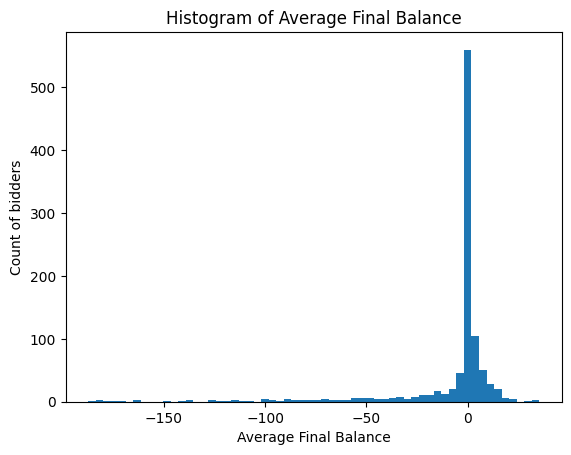

In [9]:
plt.hist(df_bidders.average_final_balance, bins=60)
plt.xlabel("Average Final Balance")
plt.ylabel("Count of bidders")
plt.title("Histogram of Average Final Balance");

# plt.savefig("images/AFB_dpi300.jpg")

The above histogram indicates an interestingly shaped distribution. The majority of bidders finished with average final balances of close to zero dollars, both above and below. The positive side of the distribution appears fairly normally distributed. However, the negative side does not exhibit the same behavior, behaving closer to (but not quite) a uniform distribution. Many bidders finished with exactly a zero dollar average final balance.

In [22]:
print(f"Percent of bidders that finished with $0: {100*len(df_bidders.loc[df_bidders.average_final_balance==0])/1000}%")

Percent of bidders that finished with $0: 26.2%


In [23]:
print(f"Percent of bidders that finished with between -$2 and $2: {100*len(df_bidders.loc[(df_bidders.average_final_balance>-2) & (df_bidders.average_final_balance<2)])/1000}%")

Percent of bidders that finished with between -$2 and $2: 56.3%


### Multivariate analysis

**I want to understand how the three variables that constitute a unique bidder impact that bidder's performance across a variety of auctions. This analysis aims to understand which combinations of `alpha`, `aggressiveness`, and `under_cut` result in highly effective and highly ineffective bidders.**

I begin by considering the impact of `under_cut` on `average_final_balance` separeately from the other two independent variables because I believe that likely does not interact with them. 

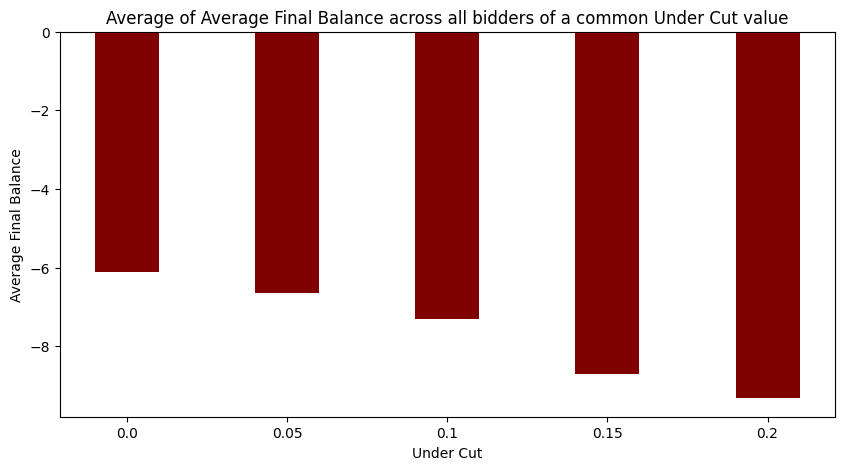

In [34]:
under_cut_values = list(df_bidders.groupby(["under_cut"])["average_final_balance"].mean().index)
undercut_strings = [str(uc_value) for uc_value in under_cut_values]
AFB_values = list(df_bidders.groupby(["under_cut"])["average_final_balance"].mean().values)

fig = plt.figure(figsize = (10, 5))

plt.bar(undercut_strings, AFB_values, color="Maroon", width=0.4)
plt.xlabel("Under Cut")
plt.ylabel("Average Final Balance")
plt.title("Average of Average Final Balance across all bidders of a common Under Cut value");

Next, I will attempt to visualize the joint impact of `alpha` and `aggressiveness` on `average_final_balance`. I create a heatmap with `alpha` on the columns, `aggressiveness` on the rows, and `average_final_balance` determining the colors of the cells. As there are actually 5 unique bidders for each combination of `alpha` and `aggressiveness` (representing the 5 values of `under_cut`), I average `average_final_balance` over these 5 bidders and the color in each cell represents this resulting average. 

I know this is a confusing amount of averaging. The outcome variable is referred to as `average_final_balance` because each unique bidder participates in many auctions (anywhere from about 10 to 45) and finishes each auction with a certain "final balance". I summarize their performance across all the auctions in which they played by taking the average of all their "final balance" values, hence `average_final_balance`. However *another* averaging is necessary for the following visualization in order to summarize `average_final_balance` for each of 200 groups of 5 bidders. 

In [17]:
# address the overlapping problem by averaging over the third attribute (under_cut)

test_df = pd.DataFrame(df_bidders.groupby(["alpha", "aggressiveness"])["average_final_balance"].mean())
test_df = test_df.reset_index()
test_df.sort_values(by="average_final_balance", ascending=False)

,alpha,aggressiveness,average_final_balance
37,0.1,0.85,18.478459
55,0.2,0.75,11.850998
35,0.1,0.75,11.253554
31,0.1,0.55,10.754804
54,0.2,0.70,10.253396
...,...,...,...
139,0.6,0.95,-114.884717
198,0.9,0.90,-123.105396
159,0.7,0.95,-136.284477
179,0.8,0.95,-163.394393


In [19]:
# create a pivot table which will be used to make a heatmap below

piv_tab = pd.pivot_table(test_df, index="aggressiveness", columns="alpha", fill_value="average_final_balance")
piv_tab

average_final_balance                                   \
alpha                            0.0        0.1        0.2        0.3   
aggressiveness                                                          
0.00                             0.0   0.000000   0.000000   0.000000   
0.05                             0.0   0.000000   0.000000   0.748814   
0.10                             0.0   0.000000   0.000000  -0.000402   
0.15                             0.0   0.000000  -0.003306   0.076686   
0.20                             0.0   0.000000   1.760911  -0.017495   
0.25                             0.0   0.000000   0.843125   1.283730   
0.30                             0.0   0.670626   2.097585   1.132926   
0.35                             0.0   0.000000   0.962706   1.314391   
0.40                             0.0   3.208628   3.879820   1.292716   
0.45                             0.0   4.270710   0.807055   0.123904   
0.50                             0.0   5.465693   4.451990   2.052352   
0.55                             0.0  10.754804   4.535903   5.817511   
0.60                             0.0   5.452012   4.154288   6.643788   
0.65                             0.0   8.420682   9.902461   9.944260   
0.70                             0.0   7.749999  10.253396   5.478521   
0.75                             0.0  11.253554  11.850998   2.678776   
0.80                             0.0   9.092255   7.239434   3.064600   
0.85                             0.0  18.478459   7.094131  -4.388190   
0.90                             0.0   6.194464  -7.729618 -20.040138   
0.95                             0.0  -4.303018 -23.247804 -43.665724   

                                                                          \
alpha                 0.4        0.5         0.6         0.7         0.8   
aggressiveness                                                             
0.00             0.000000   0.000000    0.000000    0.000000    0.000000   
0.05            -0.001001  -0.000554    0.007309    0.020978    0.078051   
0.10            -0.005647  -0.005279    0.033870    0.020275    0.387551   
0.15             0.000000   0.726834    0.172938    0.170963    0.061286   
0.20             0.006097   0.111658    0.323962    0.040384    0.899745   
0.25             0.100768   0.137825    0.108826    0.103993    0.071780   
0.30             0.102753   0.672727    1.000165    0.292147    0.053427   
0.35             2.417852   0.588560    1.311536    0.687300    1.680267   
0.40             3.672586   3.978665    2.505864    1.219729    1.158185   
0.45             1.836493   1.948651    4.354979    2.154130    3.298465   
0.50             2.115504   2.487582    3.088935   -0.762704   -0.942705   
0.55             4.835953   3.129098    0.861443    4.981106   -1.824859   
0.60             1.907425   7.758307    1.423881    1.002337   -3.997844   
0.65             5.913670   3.826541   -0.929748   -1.474722   -2.193946   
0.70             0.683117   5.736364   -2.138393   -3.693844  -19.614536   
0.75             2.115441  -5.305438   -5.487605  -12.847779  -17.212750   
0.80            -1.623085  -7.259540  -14.023460  -22.671918  -39.808288   
0.85           -14.019300 -28.536595  -40.333250  -39.426244  -54.514684   
0.90           -40.905264 -51.220013  -64.090788  -73.707371  -93.801961   
0.95           -74.002258 -88.833558 -114.884717 -136.284477 -163.394393   

                            
alpha                  0.9  
aggressiveness              
0.00              0.000000  
0.05              0.009017  
0.10              0.062357  
0.15              0.129156  
0.20              0.323222  
0.25             -0.003022  
0.30              0.855770  
0.35             -0.251056  
0.40              0.959798  
0.45              2.868670  
0.50             -0.096741  
0.55              2.232079  
0.60             -2.621676  
0.65             -6.180487  
0.70            -16.179719  
0.75            -25.307652  
0.80            -48.566777  
0.85  

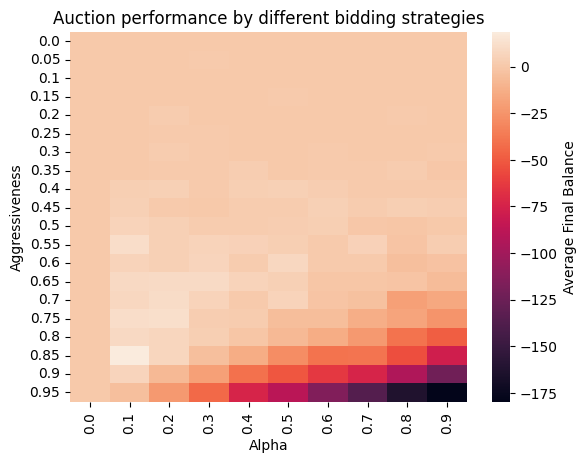

In [20]:
# create the heatmap

heatmap = sns.heatmap(piv_tab, cbar_kws={'label': 'Average Final Balance'})

# label axes
plt.xlabel("Alpha")
plt.ylabel("Aggressiveness")
plt.title("Auction performance by different bidding strategies")

plt.xticks(ticks=plt.xticks()[0], labels=[str(i/10) for i in range(10)]);
# heatmap.figure.colorbar(heatmap.collections[0], ax=heatmap.axes, label='Color Legend Title')

# plt.savefig("images/heatmap_dpq300.jpg", dpi=300)

**These results are insightful, we can see a small pocket of success in the mid to lower left and a large corner of failure in the bottom right of the heatmap.**

**Lastly, I want to be able to grab some auctions that the best and worst bidders participated in and visualize their balances by round**